# Basic linear regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import unittest
import itertools

import tensorflow as tf
from tensorflow.keras import layers
from IPython.display import clear_output

from functions import fillna_by_time, Check_fillna_by_time
unittest.main(argv=["", "Check_fillna_by_time"], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.008s

OK


## Data processing

In [67]:
building_info = pd.read_csv('.\data\\building_metadata.csv')
train_meters = pd.read_csv('.\data\\train.csv')
weather_train = pd.read_csv('.\data\\weather_train.csv')

In [3]:
building_info.head(3)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN


In [68]:
# separate tasks
electricity = train_meters[train_meters.meter==0].drop('meter', axis=1)[:100000] # careful!!!
chilledwater = train_meters[train_meters.meter==1].drop('meter', axis=1)
steam = train_meters[train_meters.meter==2].drop('meter', axis=1)
hotwater = train_meters[train_meters.meter==3].drop('meter', axis=1)

del train_meters

In [69]:
# let's start with electricity
# we should join dataframes to see the whole picture
electricity = electricity.set_index('building_id').join(
    building_info.set_index('building_id'), 
    on='building_id')
electricity.set_index(pd.Index([i for i in range(len(electricity))]), inplace=True)

In [70]:
# remove nans
electricity['floor_count'].fillna(electricity['floor_count'].median(), inplace=True)
electricity['year_built'].fillna(electricity['year_built'].median(), inplace=True)

In [71]:
for i in electricity.columns:
    part = 'has Nans!!!' if electricity[i].isna().any() else 'doesn\'t have Nans'
    print(f'column {i} {part}')

column timestamp doesn't have Nans
column meter_reading doesn't have Nans
column site_id doesn't have Nans
column primary_use doesn't have Nans
column square_feet doesn't have Nans
column year_built doesn't have Nans
column floor_count doesn't have Nans


In [72]:
print('There are', len(weather_train['site_id'].unique()), 'unique site_ids')

mean_for_site_id = 0
for i in weather_train['site_id'].unique():
    mean_for_site_id += weather_train['site_id'][weather_train['site_id'] == i].count()
mean_for_site_id /= len(weather_train['site_id'].unique())

print('But for every site_id there are in average', int(mean_for_site_id), 'rows')
print('We are going to have', int(mean_for_site_id)*len(electricity),'raws at all!!!')

There are 16 unique site_ids
But for every site_id there are in average 8735 rows
We are going to have 873500000 raws at all!!!


In [73]:
for index in weather_train['site_id'].unique():
    testing_site_id = weather_train[weather_train['site_id'] == index]
    
    with_nans = testing_site_id['air_temperature'].isna()
    for i in testing_site_id.columns:
        with_nans |= testing_site_id[i].isna()

    print('for', index, len(testing_site_id[~with_nans])/len(testing_site_id), 
          'of data doesn\'t have Nans at all')

for 0 0.5429189435336976 of data doesn't have Nans at all
for 1 0.0 of data doesn't have Nans at all
for 2 0.6747125128088353 of data doesn't have Nans at all
for 3 0.5714123006833713 of data doesn't have Nans at all
for 4 0.4361835363770921 of data doesn't have Nans at all
for 5 0.0 of data doesn't have Nans at all
for 6 0.5867683898884081 of data doesn't have Nans at all
for 7 0.0 of data doesn't have Nans at all
for 8 0.5429189435336976 of data doesn't have Nans at all
for 9 0.44123006833712985 of data doesn't have Nans at all
for 10 0.666021407424277 of data doesn't have Nans at all
for 11 0.0 of data doesn't have Nans at all
for 12 0.0 of data doesn't have Nans at all
for 13 0.49379483092337473 of data doesn't have Nans at all
for 14 0.5924575595305913 of data doesn't have Nans at all
for 15 0.006505796072864916 of data doesn't have Nans at all


In [10]:
# research features for each site_id == 0
# drop time and site_id because they are not useful now
# (time just shows us the order to sort)
testing_site_id = weather_train[weather_train['site_id'] == 0].drop('site_id', axis=1)
for i in testing_site_id.columns[1:]:
    testing_site_id = fillna_by_time(testing_site_id, i)
testing_site_id = testing_site_id.drop('timestamp', axis=1)

testing_site_id.head(3)

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0
1,24.4,6.0,21.1,-1.0,1020.2,70.0,1.5
2,22.8,2.0,21.1,0.0,1020.2,0.0,0.0


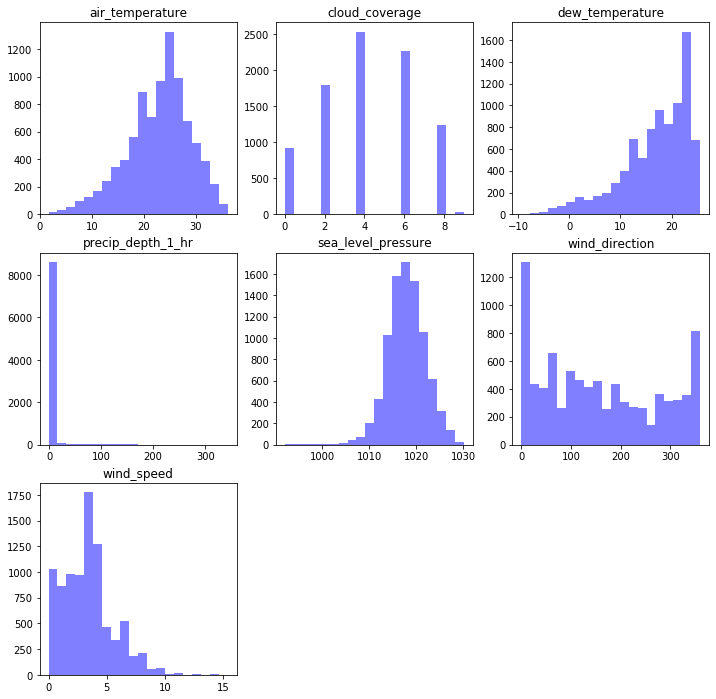

In [11]:
num_bins = 20
plt.figure(figsize=(12, 12))

index = 1
for i in testing_site_id.columns:
    plt.subplot((len(testing_site_id.columns)+2)//3, 3, index)
    plt.title(i)
    n, bins, patches = plt.hist(testing_site_id[i], num_bins, facecolor='blue', alpha=0.5)
    index += 1

plt.show()

In [12]:
# precip_depth_1_hr now doesn't have any useful info
testing_site_id = testing_site_id.drop('precip_depth_1_hr', axis=1)

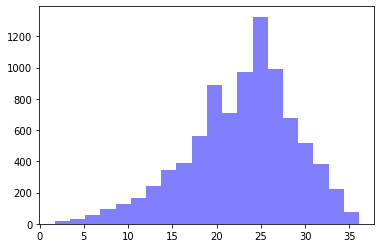

In [13]:
# let's fit normal distribution on our data
num_bins = 20


def get_in_columns(column, testing_site_id):
    y, x, patches = plt.hist(testing_site_id[column], num_bins, facecolor='blue', alpha=0.5)
    x = np.array(x[:-1], dtype='float32')
    y = np.array(y, dtype='float32')

    x = ((x - x.mean())/x.max())*10
    y /= y.max()
    
    return x, y


x, y = get_in_columns('air_temperature', testing_site_id)

In [14]:
class DestributionLayer(layers.Layer):
    def __init__(self, mu=0., st=1.):
        super(DestributionLayer, self).__init__()
        
        self.mu_var = mu
        self.st_var = st
        
        self.trainable = True
        
        
    def build(self, input_shape):
        self.mu = self.add_weight(shape=(input_shape[-1]),
                             initializer=tf.keras.initializers.Constant(self.mu_var),
                             trainable=True)
        
        self.st = self.add_weight(shape=(input_shape[-1]),
                             initializer=tf.keras.initializers.Constant(self.st_var),
                             trainable=True)
        
    def call(self, inputs):
        return tf.math.exp(-(inputs - self.mu)**2 / (2*self.st)) / tf.math.sqrt(2*np.pi*self.st)
    
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

Train on 20 samples
Epoch 1/800
20/20 [==============================] - 1s 33ms/sample - loss: 0.1817
Epoch 2/800
20/20 [==============================] - 0s 100us/sample - loss: 0.1703
Epoch 3/800
20/20 [==============================] - 0s 100us/sample - loss: 0.1631
Epoch 4/800
20/20 [==============================] - 0s 100us/sample - loss: 0.1575
Epoch 5/800
20/20 [==============================] - 0s 100us/sample - loss: 0.1529
Epoch 6/800
20/20 [==============================] - 0s 100us/sample - loss: 0.1489
Epoch 7/800
20/20 [==============================] - 0s 100us/sample - loss: 0.1453
Epoch 8/800
20/20 [==============================] - 0s 50us/sample - loss: 0.1421
Epoch 9/800
20/20 [==============================] - 0s 100us/sample - loss: 0.1391
Epoch 10/800
20/20 [==============================] - 0s 100us/sample - loss: 0.1363
Epoch 11/800
20/20 [==============================] - 0s 150us/sample - loss: 0.1337
Epoch 12/800
20/20 [==============================] - 0s

Epoch 98/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0395
Epoch 99/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0391
Epoch 100/800
20/20 [==============================] - 0s 150us/sample - loss: 0.0388
Epoch 101/800
20/20 [==============================] - 0s 50us/sample - loss: 0.0384
Epoch 102/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0381
Epoch 103/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0378
Epoch 104/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0374
Epoch 105/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0371
Epoch 106/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0368
Epoch 107/800
20/20 [==============================] - 0s 150us/sample - loss: 0.0365
Epoch 108/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0363
Epoch 109/800
20/20 [==============================] - 0s

Epoch 194/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0233
Epoch 195/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0232
Epoch 196/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0231
Epoch 197/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0230
Epoch 198/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0229
Epoch 199/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0228
Epoch 200/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0227
Epoch 201/800
20/20 [==============================] - 0s 50us/sample - loss: 0.0226
Epoch 202/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0224
Epoch 203/800
20/20 [==============================] - 0s 150us/sample - loss: 0.0223
Epoch 204/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0222
Epoch 205/800
20/20 [==============================] - 

Epoch 290/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0138
Epoch 291/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0137
Epoch 292/800
20/20 [==============================] - 0s 101us/sample - loss: 0.0136
Epoch 293/800
20/20 [==============================] - 0s 98us/sample - loss: 0.0135
Epoch 294/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0134
Epoch 295/800
20/20 [==============================] - 0s 101us/sample - loss: 0.0134
Epoch 296/800
20/20 [==============================] - 0s 101us/sample - loss: 0.0133
Epoch 297/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0132
Epoch 298/800
20/20 [==============================] - 0s 49us/sample - loss: 0.0131
Epoch 299/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0131
Epoch 300/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0130
Epoch 301/800
20/20 [==============================] - 0

Epoch 386/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0080
Epoch 387/800
20/20 [==============================] - 0s 101us/sample - loss: 0.0080
Epoch 388/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0079
Epoch 389/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0079
Epoch 390/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0078
Epoch 391/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0078
Epoch 392/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0077
Epoch 393/800
20/20 [==============================] - 0s 50us/sample - loss: 0.0077
Epoch 394/800
20/20 [==============================] - 0s 98us/sample - loss: 0.0077
Epoch 395/800
20/20 [==============================] - 0s 150us/sample - loss: 0.0076
Epoch 396/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0076
Epoch 397/800
20/20 [==============================] - 0

Epoch 482/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0052
Epoch 483/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0052
Epoch 484/800
20/20 [==============================] - 0s 101us/sample - loss: 0.0052
Epoch 485/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0052
Epoch 486/800
20/20 [==============================] - 0s 150us/sample - loss: 0.0052
Epoch 487/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0051
Epoch 488/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0051
Epoch 489/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0051
Epoch 490/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0051
Epoch 491/800
20/20 [==============================] - 0s 101us/sample - loss: 0.0051
Epoch 492/800
20/20 [==============================] - 0s 148us/sample - loss: 0.0050
Epoch 493/800
20/20 [==============================] -

Epoch 578/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0042
Epoch 579/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0041
Epoch 580/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0041
Epoch 581/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0041
Epoch 582/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0041
Epoch 583/800
20/20 [==============================] - 0s 150us/sample - loss: 0.0041
Epoch 584/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0041
Epoch 585/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0041
Epoch 586/800
20/20 [==============================] - 0s 50us/sample - loss: 0.0041
Epoch 587/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0041
Epoch 588/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0041
Epoch 589/800
20/20 [==============================] - 

Epoch 674/800
20/20 [==============================] - 0s 98us/sample - loss: 0.0039
Epoch 675/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 676/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 677/800
20/20 [==============================] - 0s 49us/sample - loss: 0.0039
Epoch 678/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 679/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 680/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 681/800
20/20 [==============================] - 0s 150us/sample - loss: 0.0039
Epoch 682/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 683/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 684/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 685/800
20/20 [==============================] - 0

Epoch 770/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 771/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 772/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 773/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 774/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 775/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 776/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 777/800
20/20 [==============================] - 0s 100us/sample - loss: 0.0039
Epoch 778/800
20/20 [==============================] - 0s 101us/sample - loss: 0.0039
Epoch 779/800
20/20 [==============================] - 0s 98us/sample - loss: 0.0039
Epoch 780/800
20/20 [==============================] - 0s 98us/sample - loss: 0.0039
Epoch 781/800
20/20 [==============================] - 0

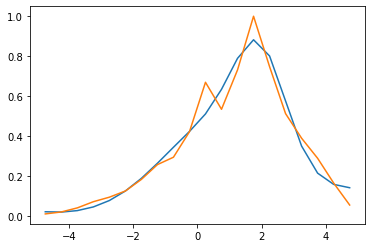

In [15]:
num_layers = 5


def loss(y, y_pred):
    return tf.reduce_mean((y_pred-y)**2)


def maxis(y):
    return tf.reduce_max(y)
  
    
def distribution_model(num_layers):
    inputs_ = layers.Input((1,))
    sp = []
    for i in range(5):
        sp.append(DestributionLayer((np.random.rand(1)*2-1)*2, 0.5)(inputs_))
    predictions = sum(sp)

    model_ = tf.keras.Model(
            inputs=inputs_, 
            outputs=predictions)

    model_.compile(optimizer=tf.keras.optimizers.RMSprop(0.01),
                  loss=loss)
    
    return model_


model = distribution_model(num_layers)
model.fit(x, y, batch_size=len(x), epochs=800)
plt.plot(x, model(x))
plt.plot(x, y)
plt.show()

### There is a long-run calculation, skip it if you have weather_train_ditributions.csv file

Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 0.1566
Train on 20 samples
20/20 [==============================] - 1s 25ms/sample - loss: 0.5082
Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 0.3528
Train on 20 samples
20/20 [==============================] - 1s 25ms/sample - loss: 0.6067
Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 0.4706
Train on 20 samples
20/20 [==============================] - 1s 25ms/sample - loss: 0.6634
Train on 20 samples
20/20 [==============================] - 1s 44ms/sample - loss: 0.0931
Train on 20 samples
20/20 [==============================] - 0s 24ms/sample - loss: 0.5882
Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 0.1222
Train on 20 samples
20/20 [==============================] - 1s 25ms/sample - loss: 0.2773
Train on 20 samples
20/20 [==============================] - 1s 45ms/sample - loss: 0.3191

20/20 [==============================] - 1s 50ms/sample - loss: 0.2756
Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 0.5058
Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 0.3988
Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 1.3026
Train on 20 samples
20/20 [==============================] - 1s 26ms/sample - loss: 0.5812
Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 0.4827


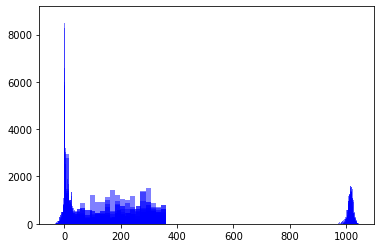

In [35]:
# we have a distribution layer and model with several of them
# so, we can simulate any distribution for any column for any site_id

columns_list = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'sea_level_pressure', 'wind_direction', 'wind_speed']
weather_distrib = pd.DataFrame(columns = ['site_id']+[i + '_' + j for i in columns_list 
                                    for j in list(itertools.chain(*[['mu' + str(i), 'st' + str(i)]
                                                                for i in range(num_layers)]))]).set_index('site_id')
for testing_site_index in weather_train['site_id'].unique():  
    
    testing_site_id = weather_train[weather_train['site_id'] == testing_site_index].drop('site_id', axis=1)
    testing_site_id = testing_site_id.drop('timestamp', axis=1)
    testing_site_id = testing_site_id.drop('precip_depth_1_hr', axis=1)
    
    for i in testing_site_id.columns:
        try:
            testing_site_id = fillna_by_time(testing_site_id, i)
        except AssertionError:
            testing_site_id[i].fillna(0, inplace=True)
            testing_site_id = fillna_by_time(testing_site_id, i)
    
    data_per_site_id = []
    for i in testing_site_id.columns:
        temp = []
        model = distribution_model(num_layers)
        x, y = get_in_columns(i, testing_site_id)
        model.fit(x, y, batch_size=len(x), epochs=800)

        for j in model.weights:
            temp.append(j.numpy()[0])

        temp = [[temp[i*2], temp[i*2+1]] for i in range(num_layers)]
        temp.sort()
        data_per_site_id.append(list(itertools.chain(*temp)))

    weather_distrib.loc[testing_site_index] = [data_per_site_id[i][j] 
                                         for i in range(len(testing_site_id.columns)) 
                                         for j in range(num_layers*2)]

In [38]:
weather_distrib.to_csv('.\data\\weather_train_ditributions.csv') 

## Regression model (naive approach)

In [16]:
weather_distrib = pd.read_csv('.\data\\weather_train_ditributions.csv').set_index('site_id')

In [61]:
# use this if you want to apply weather_distrib parametres
test_train = electricity.set_index('site_id').join(
    weather_distrib, on='site_id')

In [74]:
# use this if you don't want to apply weather_distrib parametres
test_train = electricity.copy()

In [75]:
columns_to_oh = ['primary_use', 'year_built']
for col in columns_to_oh:
    one_hot = pd.get_dummies(test_train[col])
    one_hot.columns = [f'{col}_one_hot_{str(val)}' for val in one_hot.columns]
    test_train = pd.concat([test_train, one_hot], axis=1)

In [76]:
test_train = test_train.drop(columns_to_oh, axis=1).drop('timestamp', axis=1).drop('meter_reading', axis=1)
test_train.head()

,site_id,square_feet,floor_count,primary_use_one_hot_Education,primary_use_one_hot_Entertainment/public assembly,primary_use_one_hot_Food sales and service,primary_use_one_hot_Healthcare,primary_use_one_hot_Lodging/residential,primary_use_one_hot_Manufacturing/industrial,primary_use_one_hot_Office,...,year_built_one_hot_2008.0,year_built_one_hot_2009.0,year_built_one_hot_2010.0,year_built_one_hot_2011.0,year_built_one_hot_2012.0,year_built_one_hot_2013.0,year_built_one_hot_2014.0,year_built_one_hot_2015.0,year_built_one_hot_2016.0,year_built_one_hot_2017.0
0,0,7432,3.0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,2720,3.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,5376,3.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,23685,3.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,116607,3.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
from functools import partial

In [77]:
lin_model = tf.keras.Sequential([
    layers.Input((134)),
    layers.Dense(128, activation=partial(tf.nn.leaky_relu, alpha=0.01), kernel_initializer='zeros'),
    layers.Dense(64, activation=partial(tf.nn.leaky_relu, alpha=0.01), kernel_initializer='zeros'),
    layers.Dense(32, activation=partial(tf.nn.leaky_relu, alpha=0.01), kernel_initializer='zeros'),
    layers.Dense(16, activation=partial(tf.nn.leaky_relu, alpha=0.01), kernel_initializer='zeros'),
    layers.Dense(4, activation=partial(tf.nn.leaky_relu, alpha=0.01), kernel_initializer='zeros'),
    layers.Dense(1, activation=partial(tf.nn.leaky_relu, alpha=0.01), kernel_initializer='zeros')
])
lin_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.losses.mean_absolute_error) # try "linear" mse
lin_model.fit(test_train,
              electricity['meter_reading'],
              batch_size=512,
              validation_split=0.1,
              epochs=1000
             ) # 113.0054 on 785

Train on 90000 samples, validate on 10000 samples
Epoch 1/1000
90000/90000 [==============================] - 1s 7us/sample - loss: 127.3741 - val_loss: 128.4343
Epoch 2/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 127.2305 - val_loss: 128.2914
Epoch 3/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 127.0877 - val_loss: 128.1493
Epoch 4/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 126.9466 - val_loss: 128.0095
Epoch 5/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 126.8073 - val_loss: 127.8707
Epoch 6/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 126.6690 - val_loss: 127.7330
Epoch 7/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 126.5314 - val_loss: 127.5960
Epoch 8/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 126.3957 - val_loss: 127.4619
Epoch 9/1000
90000/90000 [============================

90000/90000 [==============================] - 1s 6us/sample - loss: 119.6731 - val_loss: 120.7095
Epoch 72/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 119.5869 - val_loss: 120.6220
Epoch 73/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 119.5013 - val_loss: 120.5355
Epoch 74/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 119.4167 - val_loss: 120.4500
Epoch 75/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 119.3332 - val_loss: 120.3658
Epoch 76/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 119.2503 - val_loss: 120.2826
Epoch 77/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 119.1682 - val_loss: 120.2008
Epoch 78/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 119.0873 - val_loss: 120.1205
Epoch 79/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 119.0072 - val_loss: 120.04

90000/90000 [==============================] - 1s 6us/sample - loss: 115.1653 - val_loss: 116.0804
Epoch 144/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 115.1242 - val_loss: 116.0351
Epoch 145/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 115.0843 - val_loss: 115.9902
Epoch 146/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 115.0449 - val_loss: 115.9460
Epoch 147/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 115.0061 - val_loss: 115.9019
Epoch 148/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 114.9674 - val_loss: 115.8584
Epoch 149/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 114.9291 - val_loss: 115.8147
Epoch 150/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 114.8914 - val_loss: 115.7735
Epoch 151/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 114.8557 - val_loss

Epoch 215/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.3487 - val_loss: 113.9292
Epoch 216/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.3364 - val_loss: 113.9124
Epoch 217/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.3243 - val_loss: 113.8961
Epoch 218/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.3125 - val_loss: 113.8799
Epoch 219/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.3009 - val_loss: 113.8639
Epoch 220/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.2895 - val_loss: 113.8482
Epoch 221/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.2784 - val_loss: 113.8329
Epoch 222/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.2678 - val_loss: 113.8183
Epoch 223/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.

Epoch 287/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0105 - val_loss: 113.3955
Epoch 288/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0102 - val_loss: 113.3943
Epoch 289/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0099 - val_loss: 113.3932
Epoch 290/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0096 - val_loss: 113.3920
Epoch 291/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0094 - val_loss: 113.3910
Epoch 292/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0091 - val_loss: 113.3901
Epoch 293/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0089 - val_loss: 113.3890
Epoch 294/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0087 - val_loss: 113.3880
Epoch 295/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.

Epoch 359/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3655
Epoch 360/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3655
Epoch 361/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3655
Epoch 362/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3654
Epoch 363/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3653
Epoch 364/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3654
Epoch 365/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3653
Epoch 366/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3652
Epoch 367/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.

Epoch 431/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3646
Epoch 432/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 433/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 434/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 435/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 436/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3646
Epoch 437/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 438/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 439/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.

Epoch 503/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 504/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 505/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 506/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 507/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 508/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 509/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 510/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 511/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.

Epoch 575/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3643
Epoch 576/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 577/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3643
Epoch 578/1000
90000/90000 [==============================] - 0s 5us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 579/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3643
Epoch 580/1000
90000/90000 [==============================] - 0s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 581/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3643
Epoch 582/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 583/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.

Epoch 647/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 648/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 649/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 650/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3643
Epoch 651/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 652/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 653/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 654/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 655/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.

Epoch 719/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 720/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 721/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 722/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3643
Epoch 723/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3643
Epoch 724/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 725/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3643
Epoch 726/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 727/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.

Epoch 791/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 792/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 793/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 794/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 795/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 796/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 797/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 798/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 799/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.

Epoch 863/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 864/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 865/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 866/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 867/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 868/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 869/1000
90000/90000 [==============================] - 0s 6us/sample - loss: 113.0054 - val_loss: 113.3643
Epoch 870/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 871/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.

Epoch 935/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3646
Epoch 936/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 937/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 938/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 939/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 940/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 941/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3645
Epoch 942/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.0054 - val_loss: 113.3644
Epoch 943/1000
90000/90000 [==============================] - 1s 6us/sample - loss: 113.